In [5]:
# prompt: kết nối gg drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [25]:
! pip install ultralytics
! pip install timm

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
import timm

# End to end model

In [6]:
model_yolo = YOLO('/content/drive/MyDrive/Code/cv/OCR/model/yolov8_best.pt')
metrics = model_yolo.val(
    project='models',
    name='yolov8/detect/val'
)

Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)


100%|██████████| 755k/755k [00:00<00:00, 4.74MB/s]
val: Scanning /content/drive/MyDrive/Code/cv/OCR/data/yolo_data/val/labels.cache... 7 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7/7 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:18<00:00, 18.77s/it]


                   all          7         62      0.903      0.871      0.887      0.681
Speed: 38.9ms preprocess, 1975.1ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to models/yolov8/detect/val


In [23]:
class CRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3):
        super(CRNN, self).__init__()

        backbone = timm.create_model(
            'resnet101',
            in_chans=1,
            pretrained=True
        )

        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.gru = nn.LSTM(
            input_size=1024,
            hidden_size=hidden_size,
            num_layers=n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )

    def forward(self, x):
        x = self.backbone(x) # shape: (bs, c, h, w)
        x = x.permute(0, 3, 1, 2) # shape: (bs, w, c, h)
        x = x.view(x.size(0), x.size(1), -1)  # Remove h: (bs, w, c)
        x = self.mapSeq(x)
        x, _ = self.gru(x)
        x = self.layer_norm(x)
        x = self.out(x) # shape: (bs, seq_len, n_classes)
        x = x.permute(1, 0, 2) # Based on CTC # (seq_len, bs, n_classes)

        return x

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
hidden_size = 128
n_layers = 3
dropout_prob = 0.5
unfreeze_layers=4
crnn_model = CRNN(
    vocab_size=37,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers
).to(device)
crnn_model.load_state_dict(torch.load('/content/drive/MyDrive/Code/cv/OCR/model/ocr_crnn_resnet_best_1.pt', map_location=device))
crnn_model.to(device)
crnn_model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

CRNN(
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [8]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    decoded_sequences = []
    for seq in encoded_sequences:
        decoded_label = []
        for idx, token in enumerate(seq):
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    decoded_label.append(char)
        decoded_sequences.append(''.join(decoded_label))

    return decoded_sequences

In [7]:
def text_detection(img_path, text_det_model):
    text_det_results = text_det_model(img_path, verbose=False)[0]

    bboxes = text_det_results.boxes.xyxy.tolist()
    classes = text_det_results.boxes.cls.tolist()
    names = text_det_results.names
    confs = text_det_results.boxes.conf.tolist()

    return bboxes, classes, names, confs

In [9]:
def text_recognition(img, data_transforms, text_reg_model, idx_to_char, device):
    transformed_image = data_transforms(img)
    transformed_image = transformed_image.unsqueeze(0).to(device)
    text_reg_model.eval()
    with torch.no_grad():
        logits = text_reg_model(transformed_image).detach().cpu()
    text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)

    return text

In [19]:
def visualize_detections(img, detections):
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    for bbox, detected_class, confidence, transcribed_text in detections:
      x1, y1, x2, y2 = bbox
      plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
      plt.text(
          x1, y1 - 10, f"{detected_class} ({confidence:.2f}): {transcribed_text}",
          fontsize=9, bbox=dict(facecolor='red', alpha=0.5)
      )

    plt.show()

In [20]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.Grayscale(num_output_channels=1),
        transforms.GaussianBlur(3),
        transforms.RandomAffine(degrees=1, shear=1),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.3, interpolation=3),
        transforms.RandomRotation(degrees=2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
    'val': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
}

In [29]:
def predict(img_path, data_transforms, text_det_model, text_reg_model, idx_to_char, device, visualize=True):
    bboxes, classes, names, confs = text_detection(img_path, text_det_model)
    img = Image.open(img_path)
    predictions = []
    for bbox, cls, conf in zip(bboxes, classes, confs):
        x1, y1, x2, y2 = bbox # Lấy tọa độ bbox
        confidence = conf # Lấy confidence score
        detected_class = cls # Lấy mã ID của class
        name = names[int(cls)] # Lấy tên class theo mã ID

        # Cắt ảnh theo bbox
        cropped_image = img.crop((x1, y1, x2, y2))

        # Thực hiện text recognition trên ảnh đã cắt
        transcribed_text = text_recognition(
            cropped_image,
            data_transforms,
            text_reg_model,
            idx_to_char,
            device
        )

        # Thêm kết quả STR vào list predictions
        predictions.append((bbox, name, confidence, transcribed_text))

    # Thực hiện visualize kết quả STR nếu có
    if visualize:
        visualize_detections(img, predictions)

    return predictions

In [14]:
chars = '0123456789abcdefghijklmnopqrstuvwxyz-'
vocab_size = len(chars)
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

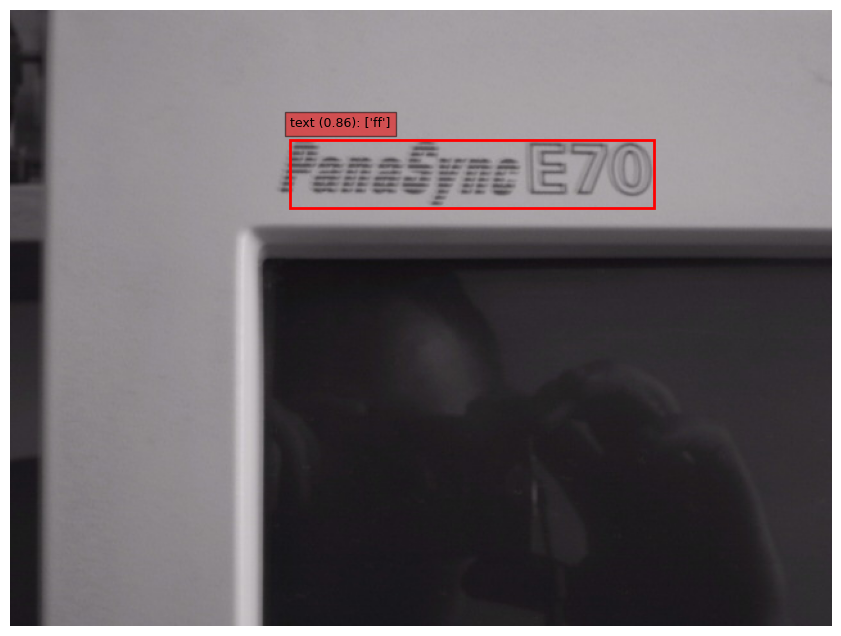

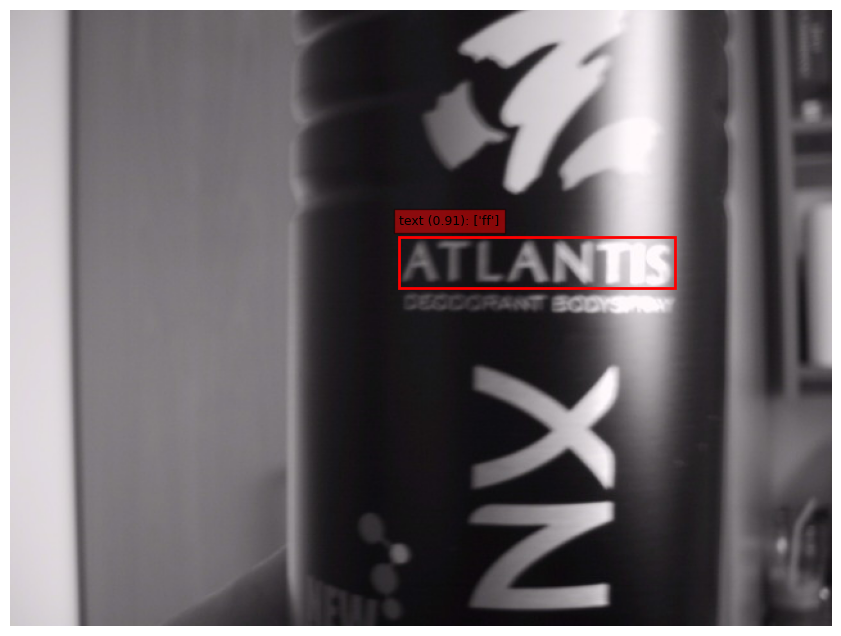

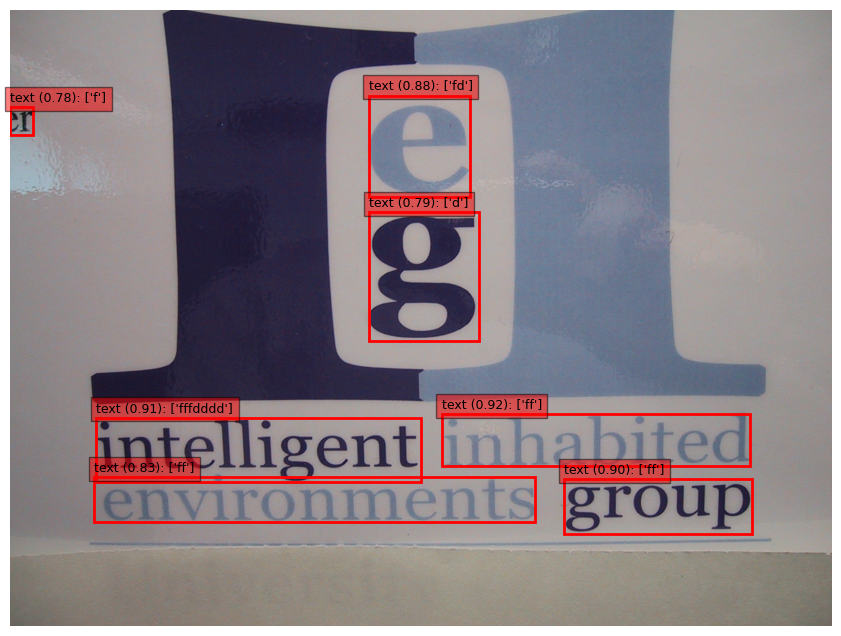

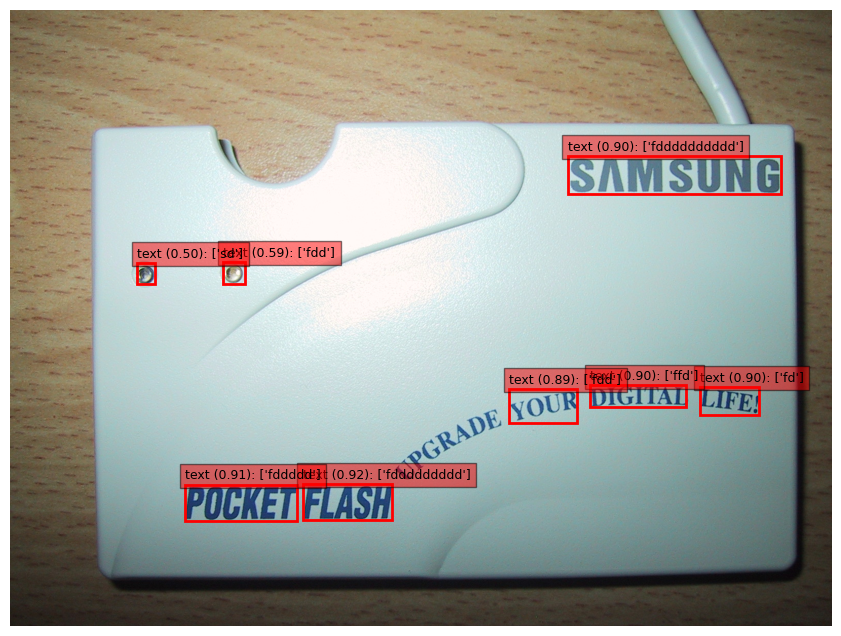

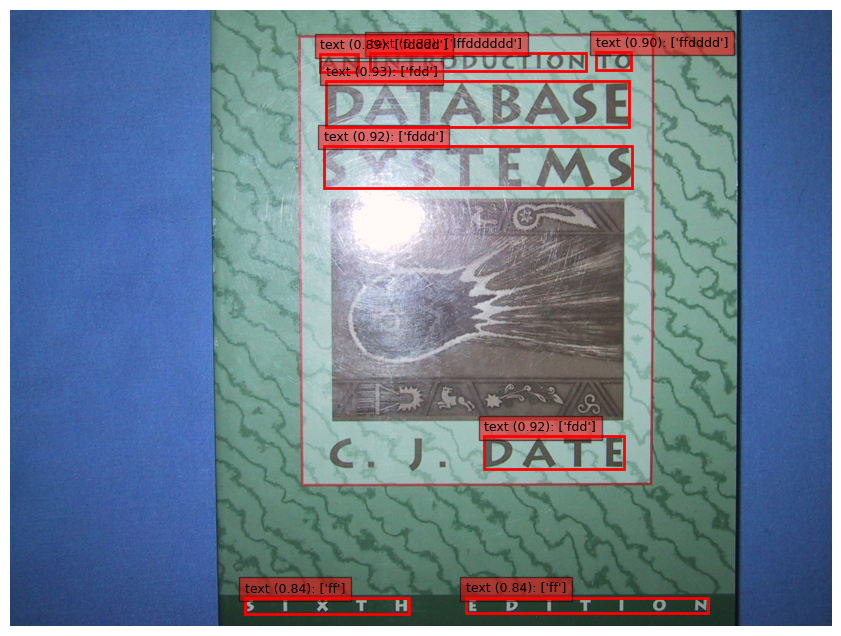

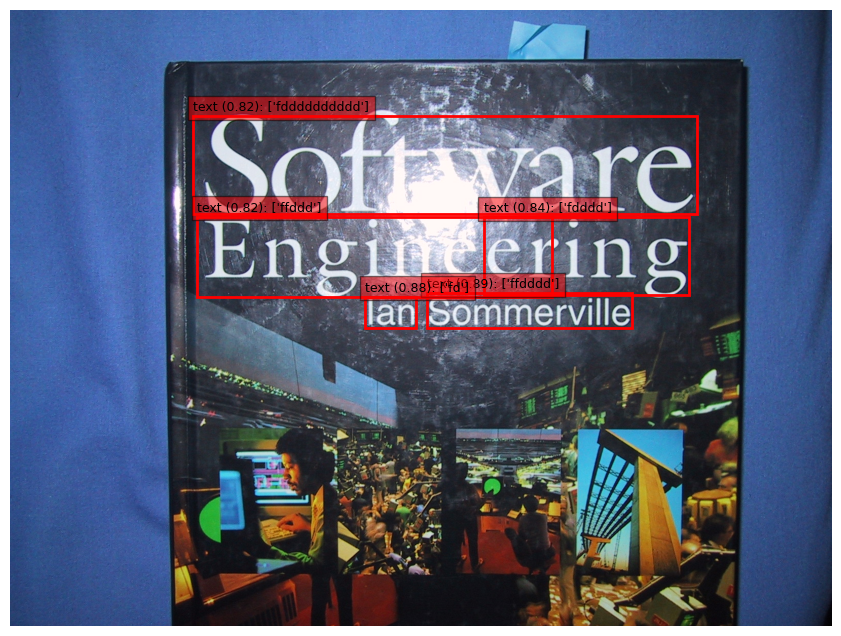

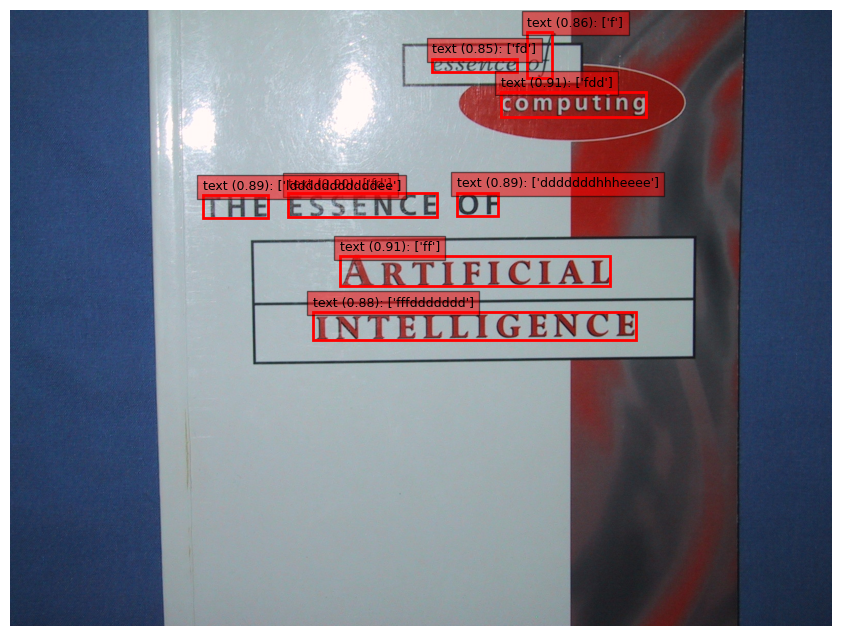

KeyboardInterrupt: 

In [30]:
img_dir = '/content/drive/MyDrive/Code/cv/OCR/data_raw/SceneTrialTrain/apanar_06.08.2002'
inf_transforms = data_transforms['val']

for img_filename in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_filename)
    predictions = predict(
        img_path,
        data_transforms=inf_transforms,
        text_det_model=model_yolo,
        text_reg_model=crnn_model,
        idx_to_char=idx_to_char,
        device=device,
        visualize=True
    )